In [26]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import seaborn as sns
import efgs
from rdkit import Chem
from IPython.display import display, Image

In [2]:
# Load chembl data
chembl_data = pd.read_csv('data/chembl_35_fg_scaf.csv')

In [3]:
# Convert the fgs column to lists with lambda function
chembl_data['fgs'] = chembl_data['fgs'].apply(lambda x: eval(x) if pd.notnull(x) else [])

In [4]:
chembl_data.head()

,smiles,inchikey,fgs,scaffolds
0,CC1=NN(c2ccc(C)c(C)c2)C(=O)/C1=N\Nc1cccc(-c2cc...,IIBBJCNVTRCTDV-QYQHSDTDSA-N,"[O=C1C(=N[N]([R])[R])C=N[N]1[R], [OH][Car], [N...",*=C1C(=NNc2cccc(-c3cccc(-c4nnn[nH]4)c3)c2)C=NN...
1,COCC1c2c(cnn2C)CCN1Cc1ccc(C)cc1,CURLUINJKUTKLO-UHFFFAOYSA-N,"[[R][O][R], [R][N]([R])[R], [Nar], [Nar]]",c1ccc(CN2CCc3cn[nH]c3C2)cc1
2,COc1cccc(N(C)C(=O)c2ccc(-c3ccc(OC)c(F)c3)s2)c1,JJJNBNRLZNDSMT-UHFFFAOYSA-N,"[[R][O][R], O=[C]([R])[N]([R])[R], [R][O][R], ...",*=C(Nc1ccccc1)c1ccc(-c2ccccc2)s1
3,O=c1[nH]c2ccc(-c3csc(-c4ccc(F)c(F)c4)n3)cc2o1,FEPSUZQURINCPW-UHFFFAOYSA-N,"[[O]=[Car], [F][R], [F][R], [Nar], [Sar], [Nar...",*=c1[nH]c2ccc(-c3csc(-c4ccccc4)n3)cc2o1
4,Cc1cc(CC#N)cc(C)c1Nc1ccnc(Nc2ccc(C#N)cc2)n1,ZKXJVUBVZRGELZ-UHFFFAOYSA-N,"[C#N, [R][NH][R], [R][NH][R], C#N, [Nar], [Nar]]",c1ccc(Nc2ccnc(Nc3ccccc3)n2)cc1


Number of unique functional groups: 14630


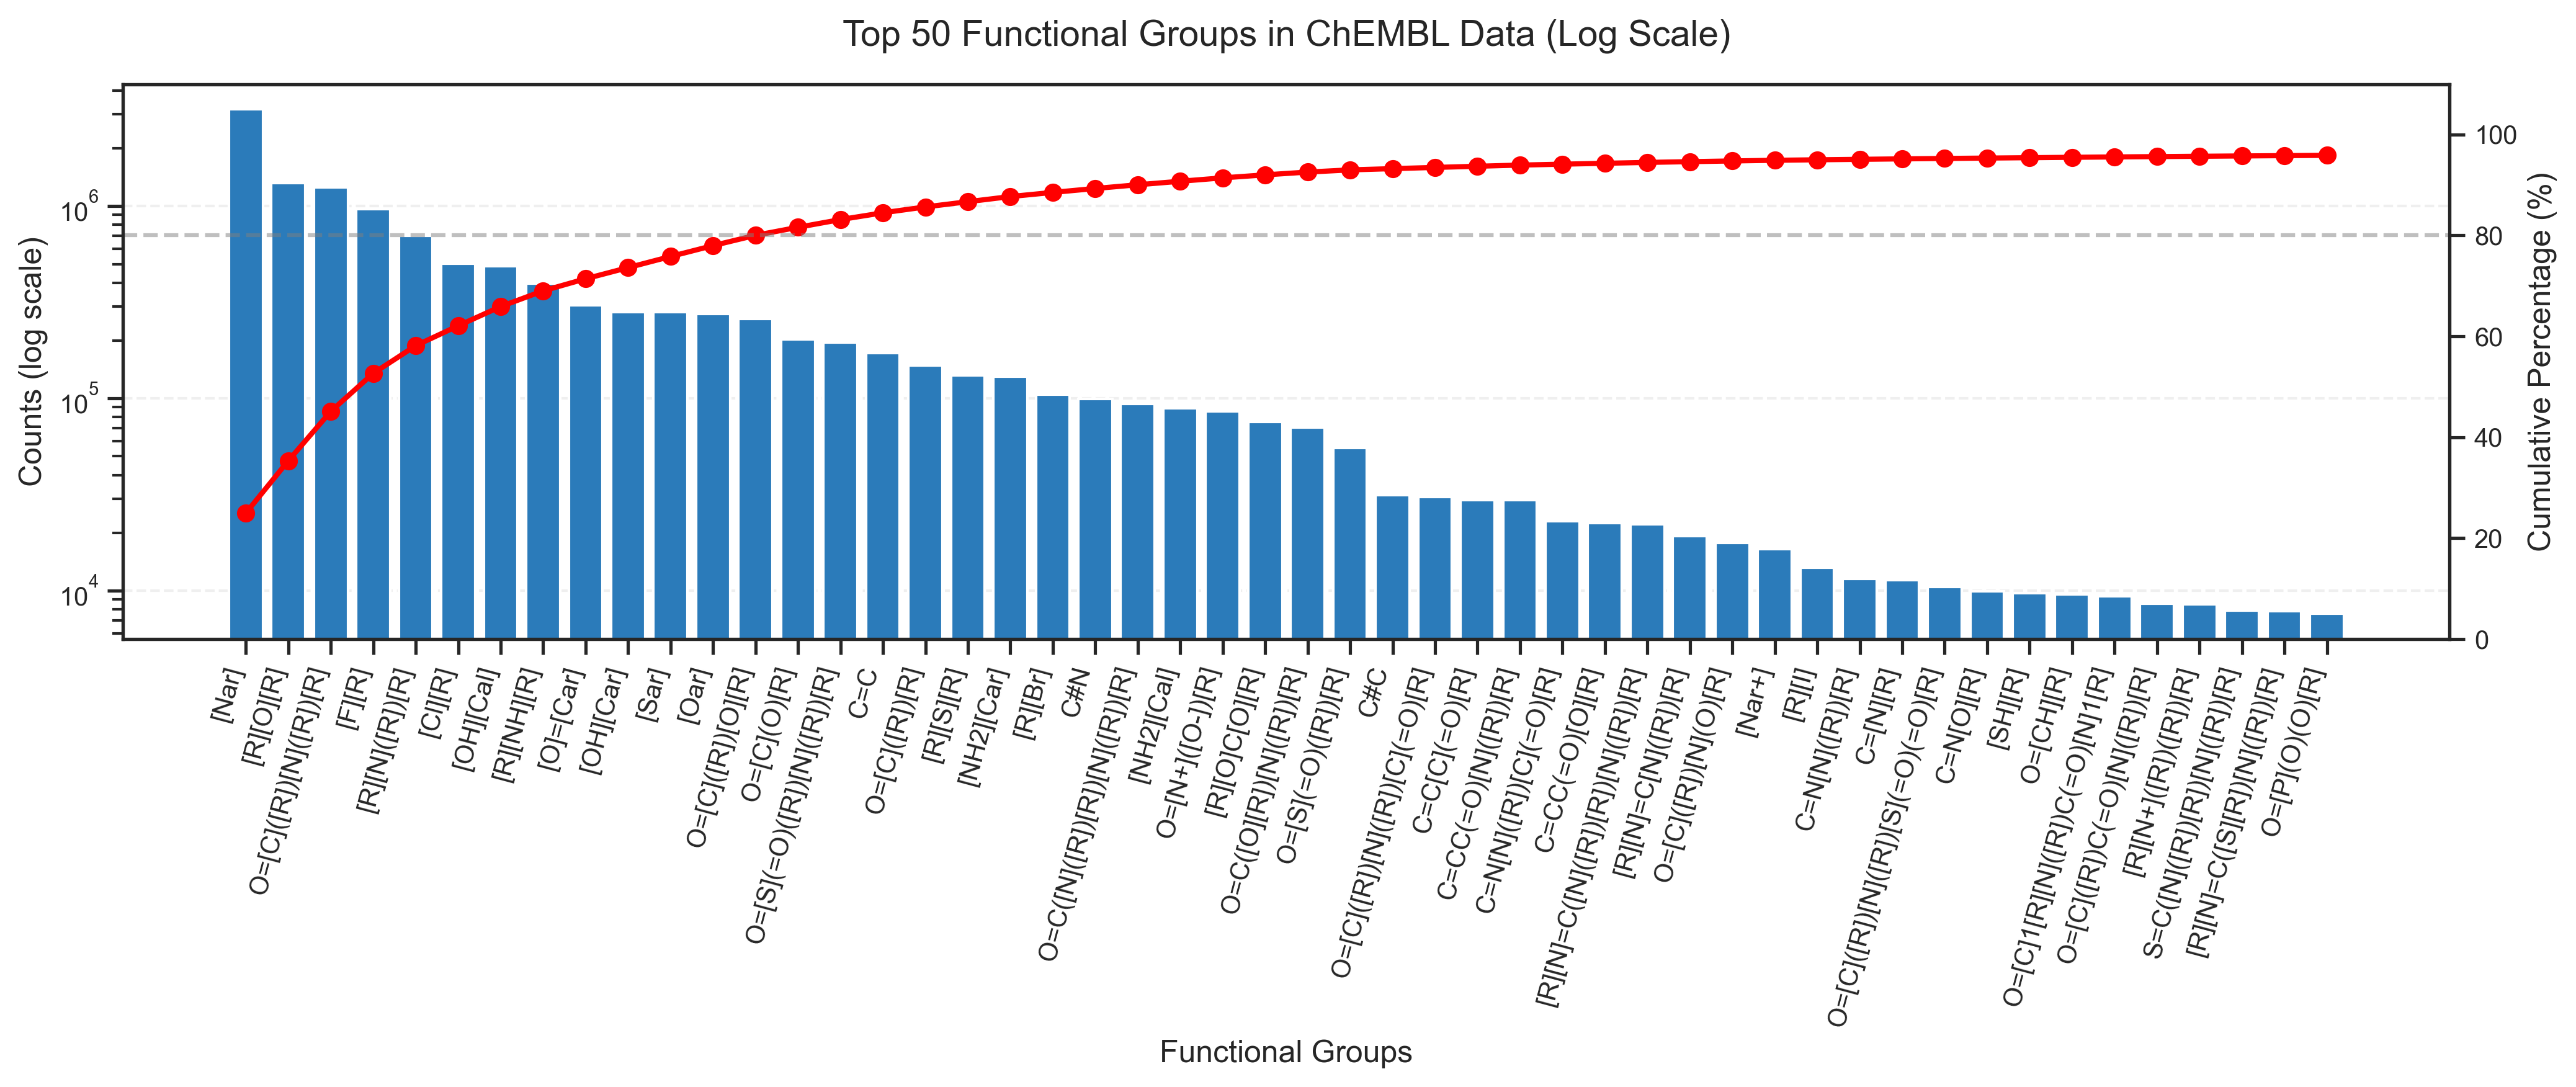

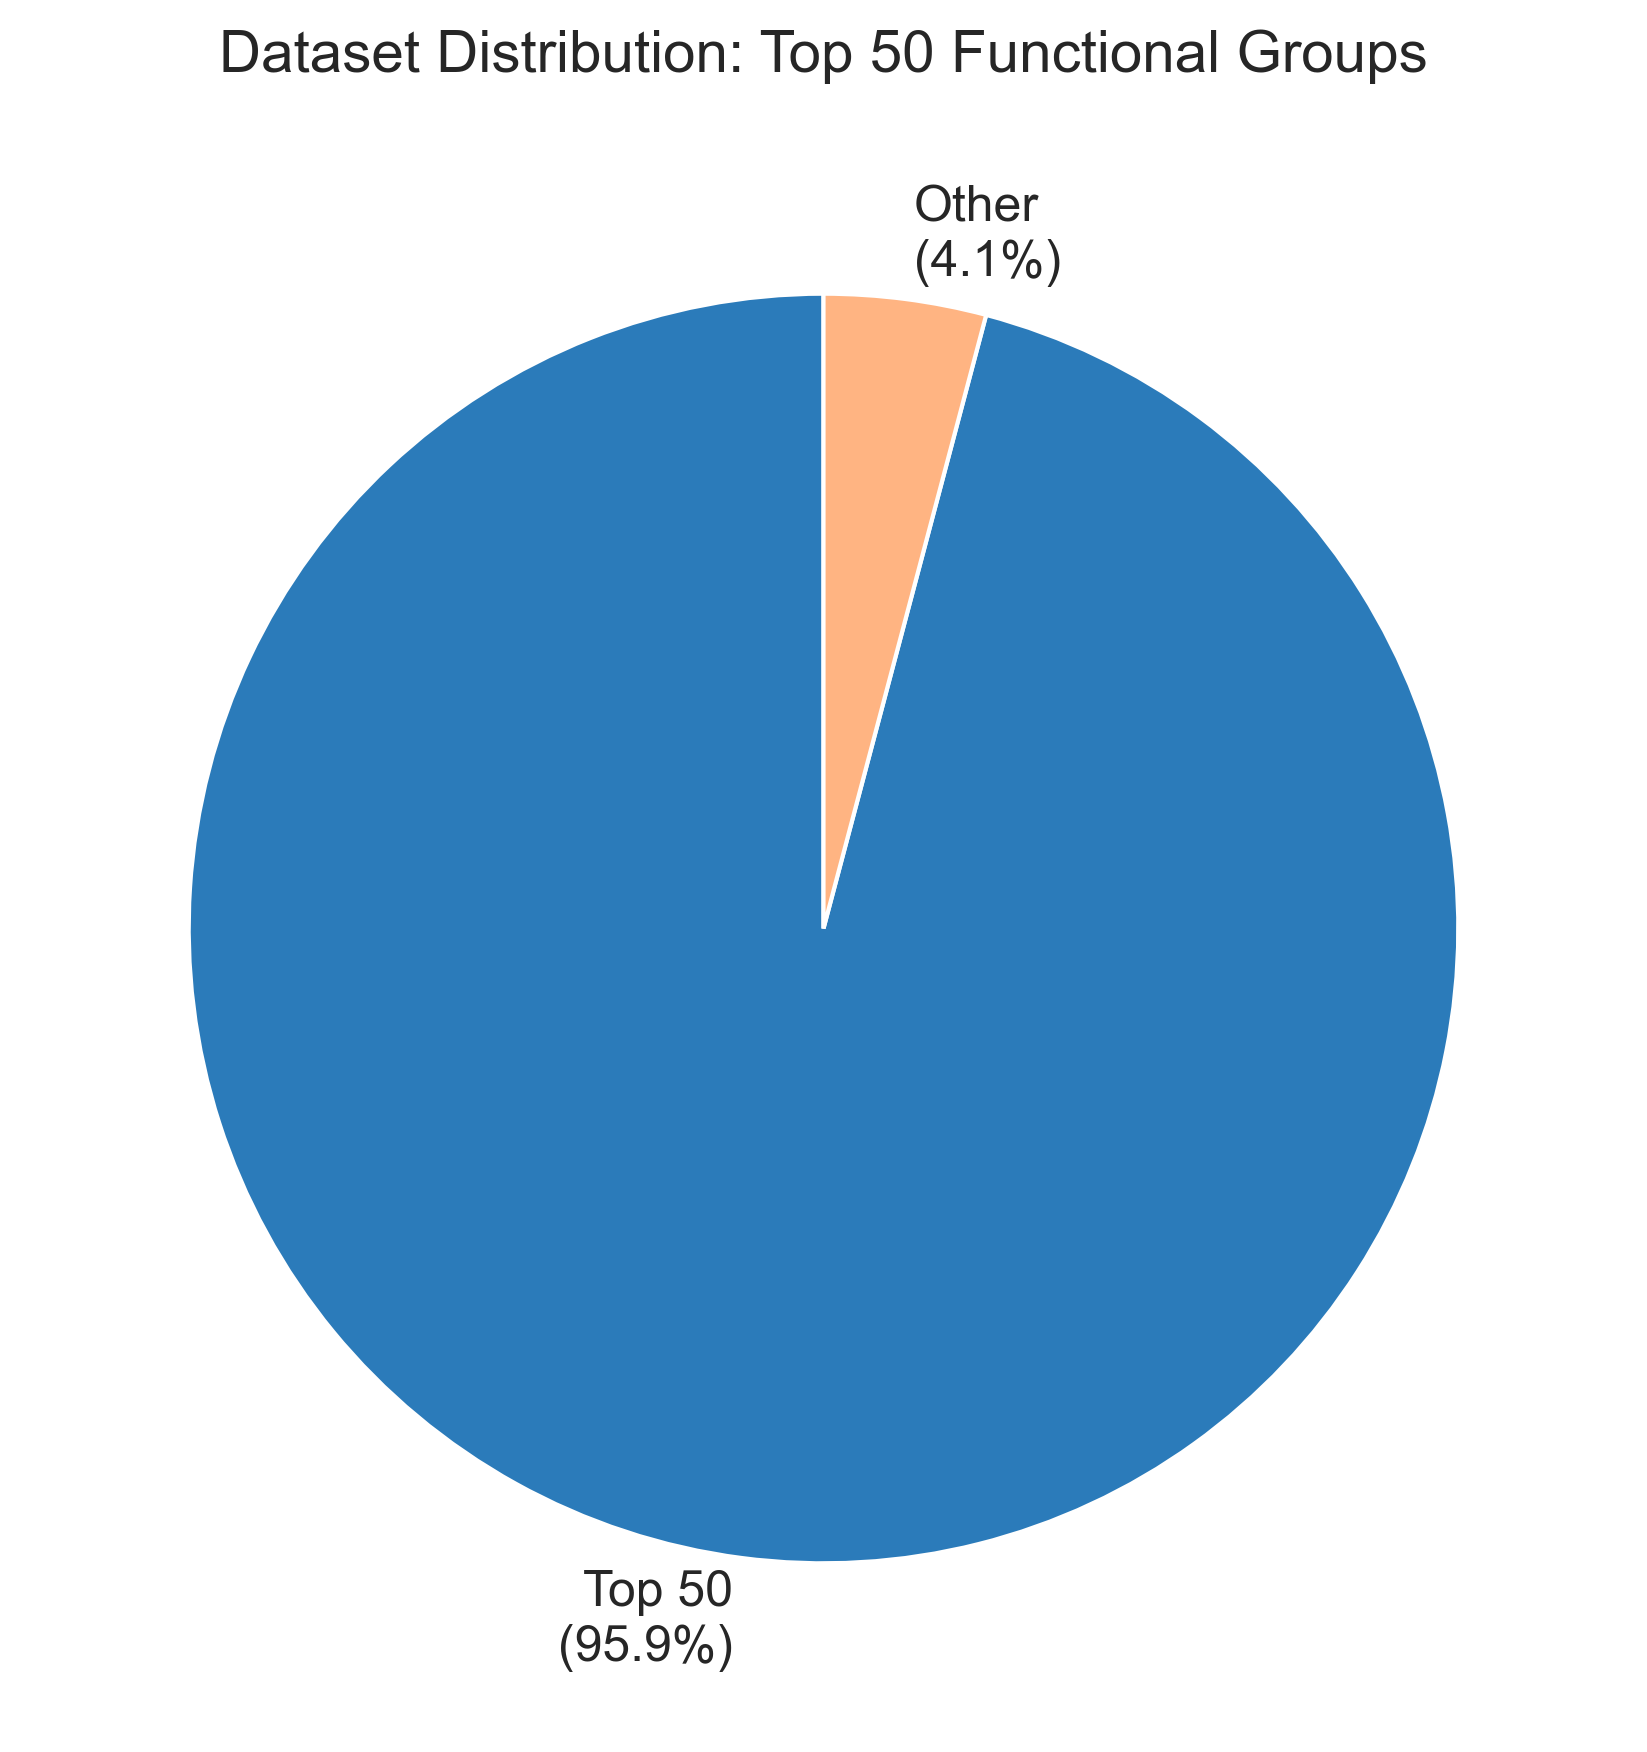

In [37]:
# Count functional groups
fg_counts = Counter()
for fgs in chembl_data['fgs']:
    fg_counts.update(fgs)

# how many unique fgs
num_unique_fgs = len(fg_counts)

print(f"Number of unique functional groups: {num_unique_fgs}")

# Only keep top 50 for display
top_fg = dict(sorted(fg_counts.items(), key=lambda item: item[1], reverse=True)[:50])

labels = list(top_fg.keys())
values = np.array(list(top_fg.values()))
total_count = sum(fg_counts.values())

# Cumulative percentage (based on entire dataset)
cum_percentage = np.cumsum(values) / total_count * 100

# Style settings for cleaner thesis look
sns.set_theme(style="ticks")  # Removes background grid
plt.rcParams.update({
    "font.size": 12,
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10
})

fig, ax1 = plt.subplots(figsize=(14, 6), dpi=300)

# Bar chart with logarithmic y-axis
bars = ax1.bar(range(len(labels)), values, color=sns.color_palette("Blues")[4])
ax1.set_xlabel('Functional Groups')
ax1.set_ylabel('Counts (log scale)')
ax1.set_yscale('log')
ax1.set_xticks(range(len(labels)))
ax1.set_xticklabels(labels, rotation=75, ha='right')

# Add subtle horizontal grid only
ax1.yaxis.grid(True, linestyle='--', alpha=0.3)
ax1.xaxis.grid(False)

# Cumulative percentage line (on secondary y-axis, linear scale)
ax2 = ax1.twinx()
ax2.plot(range(len(labels)), cum_percentage, color='red', marker='o', linewidth=2)
ax2.set_ylabel('Cumulative Percentage (%)')
ax2.set_ylim(0, 110)
ax2.axhline(80, color='gray', linestyle='--', alpha=0.5)

plt.title('Top 50 Functional Groups in ChEMBL Data (Log Scale)', pad=15)
plt.tight_layout()

plt.savefig("images/top50_pareto_log.png", dpi=300, bbox_inches='tight')

plt.show()


# Total counts
total_count = sum(fg_counts.values())
top_50_count = sum([count for _, count in fg_counts.most_common(50)])
rest_count = total_count - top_50_count

# Percentages
top_50_pct = top_50_count / total_count * 100
rest_pct = rest_count / total_count * 100

# Seaborn color palette
colors = [sns.color_palette("Blues")[4], sns.color_palette("pastel")[1]]

# High-resolution figure
fig, ax = plt.subplots(figsize=(6, 6), dpi=300)

# Only returns wedges and texts when autopct=None
wedges, texts = ax.pie(
    [top_50_count, rest_count],
    labels=[f"Top 50\n({top_50_pct:.1f}%)", f"Other\n({rest_pct:.1f}%)"],
    colors=colors,
    startangle=90,
    wedgeprops={'edgecolor': 'white'}
)

# Style text
for text in texts:
    text.set_fontsize(12)

ax.set_title('Dataset Distribution: Top 50 Functional Groups', fontsize=14, pad=15)
plt.tight_layout()
plt.savefig("images/top50_pie.png", dpi=300, bbox_inches='tight')
plt.show()


In [43]:
# what percent of functional groups appear less than 100 times
num_fgs_less_100 = sum(1 for count in fg_counts.values() if count <= 1)
print(f"Count of functional groups appearing less than 100 times: {num_fgs_less_100}")
# print the first smiles of a functional group appearing less than 100 times
for idx, fgs in enumerate(chembl_data['fgs']):
    if any(fg_counts[fg] <= 1 for fg in fgs):
        print(f"First SMILES meeting criteria: {chembl_data['smiles'].iloc[idx]}")
        break

percent_fgs_less_100 = num_fgs_less_100 / num_unique_fgs * 100

print(f"Percentage of functional groups appearing less than 100 times: {percent_fgs_less_100:.2f}%")

# what percent is the most common fg
most_common_fg_count = max(fg_counts.values())
print(f"Count of the most common functional group: {most_common_fg_count}")
percent_most_common_fg = most_common_fg_count / total_count * 100

print(f"Percentage of the most common functional group: {percent_most_common_fg:.2f}%")


Count of functional groups appearing less than 100 times: 6427
First SMILES meeting criteria: CS(=O)(=O)CN1C2=C(C(c3ccc(Br)cc3)Oc3ccccc32)C(c2ccc(Br)cc2)n2ncnc21
Percentage of functional groups appearing less than 100 times: 43.93%
Count of the most common functional group: 3188978
Percentage of the most common functional group: 24.99%


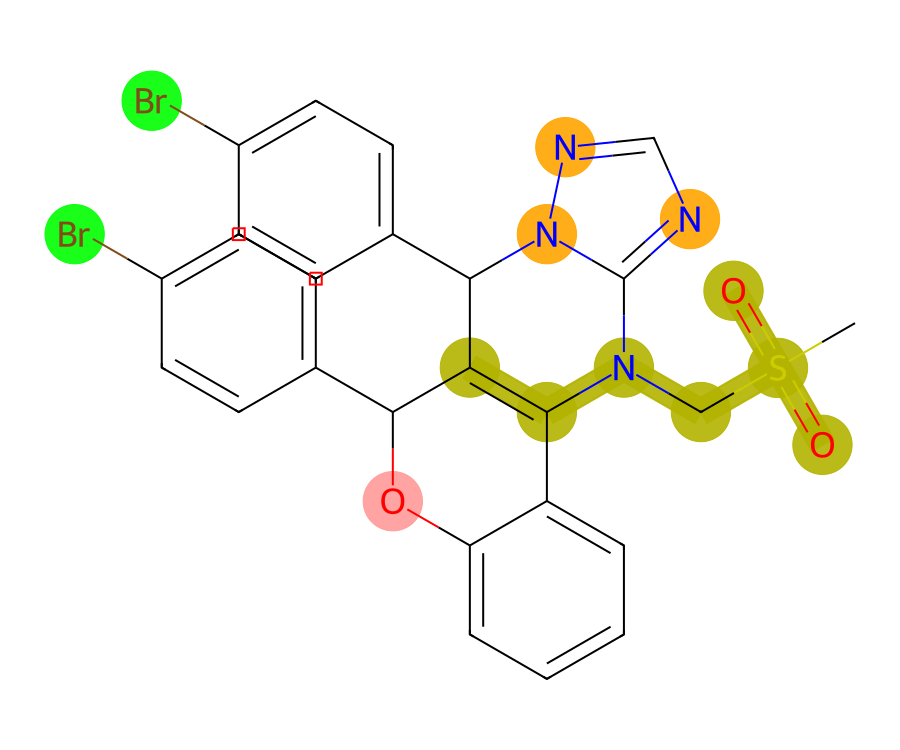

In [44]:
target_smiles = 'CS(=O)(=O)CN1C2=C(C(c3ccc(Br)cc3)Oc3ccccc32)C(c2ccc(Br)cc2)n2ncnc21'

target_mol = Chem.MolFromSmiles(target_smiles)

img_text, _, _, _ = efgs.get_dec_fgs(target_mol)

display(Image(data=img_text))

# save the image
with open(f"images/labeled_{target_smiles}.png", "wb") as f:
    f.write(img_text)